## Data Inspection & Cleaning

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt
import copy
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_stata("BankDataforML.dta")

In [3]:
data.head()

,idperson,bankid,reg_code,loan_type,currency,price_nom,price_real,risk_class,last_reclass_date,overdue_date,...,first_classification_date,last_classification_date,birth_day,education,employment,family_members,gender,ispe,marital_status,address
0,1.107040e+12,19300,19300-20180514-047755,5,AMD,18.0,12.620000,0,,,...,NaT,NaT,27/03/1987,Բարձրագույն մասնագիտական,Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ըն...,4.0,M,Y,Ամուսնացած (գրանցված և փաստացի),16851206
1,1.107040e+12,19300,19300-20200722-003208,7,AMD,18.0,19.559999,0,,,...,NaT,NaT,27/03/1987,Բարձրագույն մասնագիտական,Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ըն...,4.0,M,Y,Ամուսնացած (գրանցված և փաստացի),16851206
2,1.107040e+12,19300,19300-20180515-130154,5,EUR,6.0,6.150000,0,,,...,NaT,NaT,27/03/1987,Բարձրագույն մասնագիտական,Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ըն...,4.0,M,Y,Ամուսնացած (գրանցված և փաստացի),16851206
3,1.107040e+12,19300,19300-20190531-003194,7,AMD,12.0,12.920000,0,,,...,NaT,NaT,27/03/1987,Բարձրագույն մասնագիտական,Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ըն...,4.0,M,Y,Ամուսնացած (գրանցված և փաստացի),16851206
4,1.107040e+12,19300,19300-20181106-001507,7,AMD,12.0,12.930000,0,,,...,NaT,NaT,27/03/1987,Բարձրագույն մասնագիտական,Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ըն...,4.0,M,Y,Ամուսնացած (գրանցված և փաստացի),16851206


In [4]:
len(data)

1617745

#### Price Real

In [5]:
Q1 = data['price_real'].quantile(0.25) #quantile 1
Q3 = data['price_real'].quantile(0.75) #quantile 3

IQR = Q3 - Q1 

lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3 + 1.5 * IQR

In [6]:
data = data[data.price_real <= upper_bound]
data.reset_index(inplace = True, drop = True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611362 entries, 0 to 1611361
Data columns (total 48 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   idperson                   1611362 non-null  float64       
 1   bankid                     1611362 non-null  int32         
 2   reg_code                   1611362 non-null  object        
 3   loan_type                  1611362 non-null  int8          
 4   currency                   1611362 non-null  object        
 5   price_nom                  1611362 non-null  float32       
 6   price_real                 1611362 non-null  float32       
 7   risk_class                 1611362 non-null  int8          
 8   last_reclass_date          1611362 non-null  object        
 9   overdue_date               1611362 non-null  object        
 10  collateral_id              1611362 non-null  int16         
 11  volume_contract            1609097 no

#### Contract Date

In [8]:
data['contract_date'] = pd.to_datetime(data['contract_date'], format = "%Y/%m/%d")

In [9]:
data['contract_date'].describe()

count                 1611362
unique                   3275
top       2020-12-07 00:00:00
freq                     5509
first     2002-12-04 00:00:00
last      2021-05-20 00:00:00
Name: contract_date, dtype: object

#### Risk class

In the data inspection phase, it was observed that two additional values exist that are not consistent with the usual 5 risk classification categories. Since the anomalous values are limited to only 6 instances, we can remove them.

In [10]:
data["risk_class"].value_counts()

0    1313901
4     186539
1      65626
3      27155
2      18135
5          4
7          2
Name: risk_class, dtype: int64

In [11]:
data = data[~data['risk_class'].isin([5, 7])]

In [12]:
data.reset_index(inplace = True, drop = True)

#### Last reclass date

To utilize column that has more than 75% mssing values and indicates when was the last date that the loan's risk class was changed, we decided to create a binary indicator of classification ( 0 indicating never classified, 1 indicating has been classified).

In [13]:
data.last_reclass_date.value_counts()

              1224542
2021-04-30      57025
2021-03-31      47960
2021-02-28      16370
2020-11-30      13514
               ...   
2009-04-18          1
2010-04-30          1
2009-11-06          1
2009-04-30          1
2020-05-12          1
Name: last_reclass_date, Length: 659, dtype: int64

In [14]:
1229320/len(data) #missing values

0.7629102445393817

In [15]:
data['last_reclass_date_bin'] = data['last_reclass_date'].apply(lambda x: 0 if x == "" else 1)

In [16]:
data['last_reclass_date_bin'].value_counts()

0    1224542
1     386814
Name: last_reclass_date_bin, dtype: int64

#### Overdue date

To utilize column that has more than 83% mssing values indicating whether the loan had an overdueness, we decided to create a binary indicator of classification ( 0 indicating the loan wasn't overdue, 1 otherwise).

In [17]:
data['overdue_date'].value_counts()

              1353662
2021-05-17       4542
2020-07-27       3880
2020-07-20       2934
2021-02-25       2923
               ...   
2014-08-13          1
2009-03-10          1
2009-05-12          1
2009-12-04          1
2019-03-09          1
Name: overdue_date, Length: 2183, dtype: int64

In [18]:
1358640/len(data)

0.8431656319273954

In [19]:
data['overdue_date_bin'] = data['overdue_date'].apply(lambda x: 0 if x == "" else 1)

In [20]:
data['overdue_date_bin'].value_counts()

0    1353662
1     257694
Name: overdue_date_bin, dtype: int64

#### Volume Actual 

###### Exchange Rates

In [21]:
rates = pd.read_csv("Exchange Rates.csv") #Source - Central Bank

In [22]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4819 non-null   object 
 1   EUR     4819 non-null   float64
 2   USD     4819 non-null   float64
dtypes: float64(2), object(1)
memory usage: 113.1+ KB


In [23]:
rates.head()

,Date,EUR,USD
0,02/12/2002,581.53,585.81
1,03/12/2002,578.25,585.81
2,04/12/2002,584.57,586.51
3,05/12/2002,587.57,586.51
4,06/12/2002,585.62,586.15


In [24]:
rates.rename(columns={'Date':'contract_date'}, inplace = True)

In [25]:
rates['contract_date'] = pd.to_datetime(rates['contract_date'], format = "%d/%m/%Y")

In [26]:
rates['contract_date'].describe()

count                    4819
unique                   4819
top       2002-12-02 00:00:00
freq                        1
first     2002-12-02 00:00:00
last      2021-12-30 00:00:00
Name: contract_date, dtype: object

In [27]:
date_range = pd.date_range(start=rates['contract_date'].min(), end=rates['contract_date'].max())

rates.set_index('contract_date', inplace=True)
rates = rates.reindex(date_range)

# Forward fill missing values since for all the days when there is no exchange rate, it remains the previous one
rates.fillna(method='ffill', inplace=True)

rates.reset_index(inplace=True)
rates.rename(columns={'index': 'contract_date'}, inplace=True)

In [28]:
rates.head()

,contract_date,EUR,USD
0,2002-12-02,581.53,585.81
1,2002-12-03,578.25,585.81
2,2002-12-04,584.57,586.51
3,2002-12-05,587.57,586.51
4,2002-12-06,585.62,586.15


In [29]:
data = data.dropna(subset=['volume_actual'])

In [30]:
data = pd.merge(data, rates, on = "contract_date", how = "left")

In [31]:
def convert_to_amd(row):
    if row['currency'] == "USD":
        return row['volume_actual']*row['USD']
    elif row['currency'] =='EUR':
        return row['volume_actual']*row['EUR']
    else: return row['volume_actual']

In [32]:
data['amountAMD'] = data.apply(convert_to_amd, axis = 1)

In [33]:
print("Count of loans equal to 0 drams: ", data['amountAMD'][data['amountAMD'] ==0].count())
print("Count of loans smaller than 3,000 drams: ", data['amountAMD'][data['amountAMD'] <3000].count())
print("Count of loans equal to 3,000 drams: ", data['amountAMD'][data['amountAMD'] == 3000].count())

Count of loans equal to 0 drams:  28358
Count of loans smaller than 3,000 drams:  28836
Count of loans equal to 3,000 drams:  48092


As a lower bound for Amount in AMD 3000 drams was chosen.

In [34]:
data = data[data['amountAMD'] >=3000]

In [35]:
data.reset_index(inplace = True, drop = True)

In [36]:
data['amountAMD'].describe()

count    1.580255e+06
mean     1.544125e+07
std      1.077355e+09
min      3.000000e+03
25%      1.044747e+05
50%      2.145313e+05
75%      5.389174e+05
max      1.048446e+12
Name: amountAMD, dtype: float64

In [37]:
Q1 = data['amountAMD'].quantile(0.25) #quantile 1
Q3 = data['amountAMD'].quantile(0.75) #quantile 3

IQR = Q3 - Q1 

lower_bound = 3000
upper_bound = Q3 + 1.5 * IQR

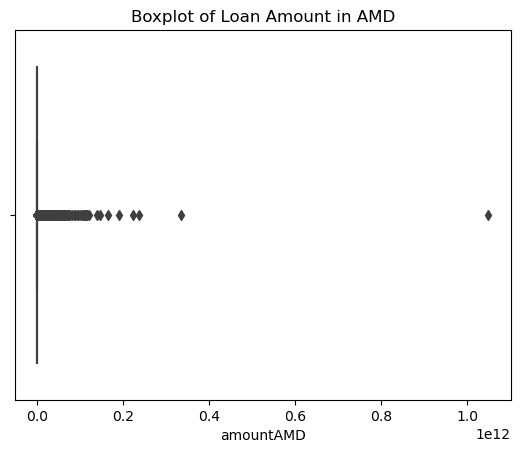

In [38]:
sns.boxplot(x=data['amountAMD'])
plt.title('Boxplot of Loan Amount in AMD')
plt.show()

In [39]:
data = data[(data['amountAMD'] >= lower_bound) & (data['amountAMD'] <= upper_bound)]

In [40]:
data.reset_index(inplace = True, drop = True)

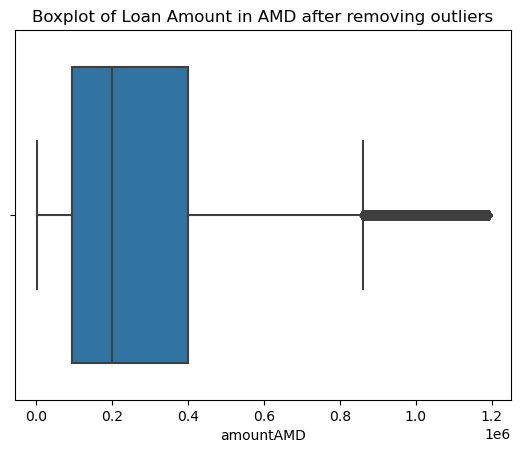

In [41]:
sns.boxplot(x=data['amountAMD'])
plt.title('Boxplot of Loan Amount in AMD after removing outliers')
plt.show()

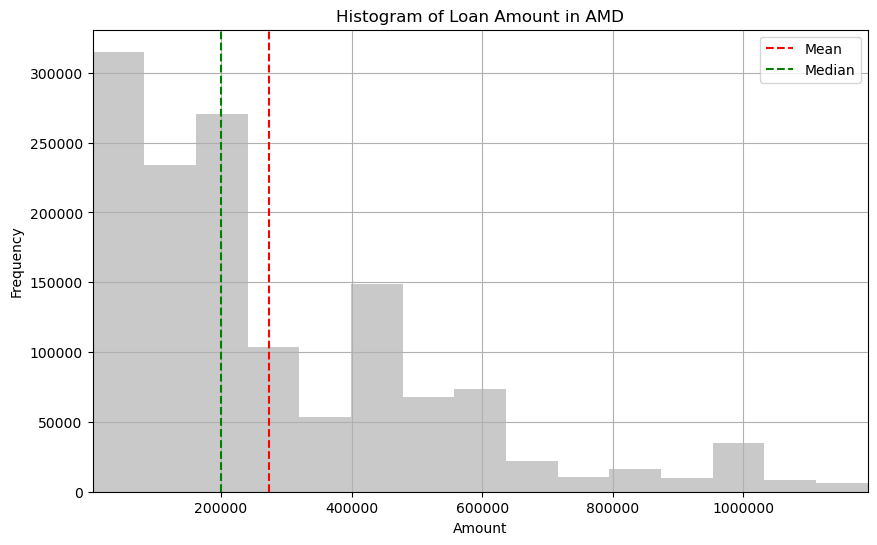

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data['amountAMD'], bins=15, color='#B8B8B8', edgecolor='none')

mean = data['amountAMD'].mean()
median = data['amountAMD'].median()

plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(median, color='green', linestyle='--', label='Median')

plt.xlim(data['amountAMD'].min(), data['amountAMD'].max())

plt.ticklabel_format(style='plain', useOffset=False)
plt.title('Histogram of Loan Amount in AMD')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True)
plt.show()

#### Age

Based on the two existing columns we can find the age of a customer when taking the loan. 
1. Convert both the Birthdate and contract_date columns from object to datetime.
2. Separately compare the month and the day from contract_date to Birthdate.

In [43]:
data['birthdate'] = pd.to_datetime(data['birthdate'])
data['contract_date'] = pd.to_datetime(data['contract_date'])

data['Age'] = data['contract_date'].dt.year - data['birthdate'].dt.year
is_before_birthday = (data['contract_date'].dt.month < data['birthdate'].dt.month) | \
                     ((data['contract_date'].dt.month == data['birthdate'].dt.month) &
                      (data['contract_date'].dt.day < data['birthdate'].dt.day))
data['Age'] -= is_before_birthday.astype(int)

In [44]:
Q1 = data['Age'].quantile(0.25) #quantile 1
Q3 = data['Age'].quantile(0.75) #quantile 3

IQR = Q3 - Q1 

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [45]:
# Removing anomalies
data = data[~((data['Age'] < 16) & (data['marital_status'] == "Ամուսնացած (գրանցված և փաստացի)"))]

In [46]:
data.reset_index(inplace = True, drop = True)

In [47]:
data = data[(data['Age'] >= lower_bound) & (data['Age'] <= upper_bound)]
data.reset_index(inplace = True, drop = True)

In [48]:
data.Age.describe()

count    1.374133e+06
mean     3.762130e+01
std      1.199684e+01
min      9.000000e+00
25%      2.800000e+01
50%      3.500000e+01
75%      4.600000e+01
max      7.300000e+01
Name: Age, dtype: float64

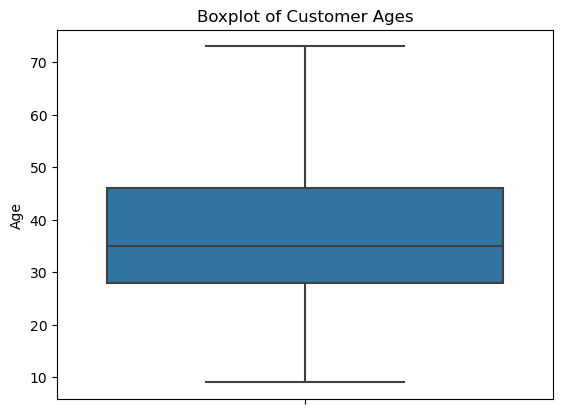

In [49]:
sns.boxplot(y=data['Age'])
plt.title('Boxplot of Customer Ages')
plt.ylabel('Age')
plt.show()

#### Fico Score

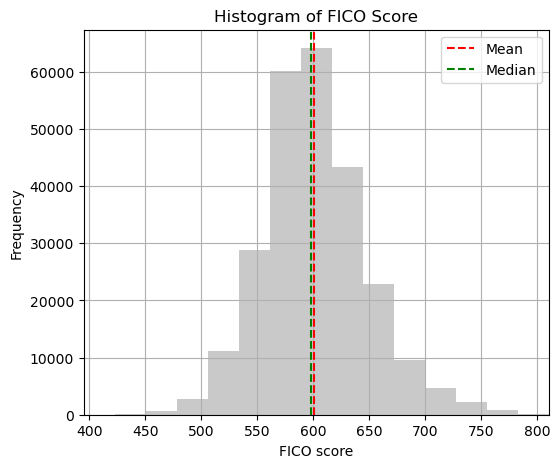

In [50]:
plt.figure(figsize=(6, 5))
sns.histplot(data['fico_score'], bins=15, color='#B8B8B8', edgecolor='none')

mean = data['fico_score'].mean()
median = data['fico_score'].median()

plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(median, color='green', linestyle='--', label='Median')

plt.xlim(data['fico_score'].min(), data['fico_score'].max())

plt.ticklabel_format(style='plain', useOffset=False)
plt.title('Histogram of FICO Score')
plt.xlabel('FICO score')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True)
plt.show()

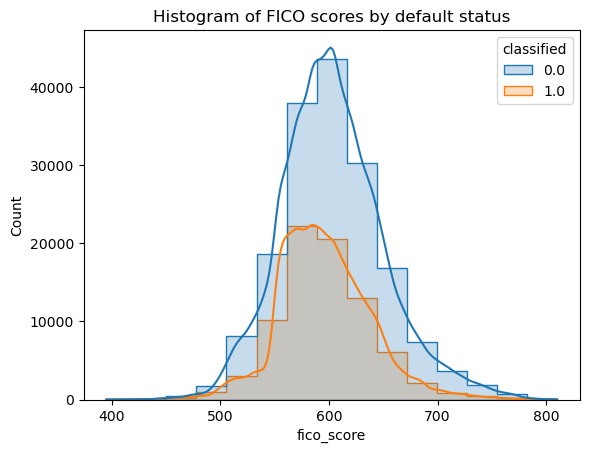

In [51]:
sns.histplot(data = data, x = "fico_score", hue = "classified", element = "step", bins = 15, kde = True)
plt.title("Histogram of FICO scores by default status")
plt.show()

In [52]:
data['has_fico_score'] = data['fico_score'].notnull().astype(int)

In [53]:
data['has_fico_score'].value_counts()

0    1122572
1     251561
Name: has_fico_score, dtype: int64

#### Income

In [54]:
data['income'] = data.groupby('idperson')['income'].transform(lambda x: x.ffill().bfill())

In [55]:
data['income'].describe()

count    4.002130e+05
mean     2.111250e+05
std      1.827902e+05
min      3.191700e+04
25%      9.267000e+04
50%      1.464482e+05
75%      2.578900e+05
max      1.152300e+06
Name: income, dtype: float64

We want to check whether there are some banks that do not check income of a consumer at all.

In [56]:
nan_income_banks = data.groupby("bankid")["income"].apply(lambda x: x.isna().all())

In [57]:
nan_income_banks

bankid
11500    False
11800    False
15100    False
15700    False
16000    False
16300    False
16600    False
19300    False
20500    False
20800    False
21400    False
21700    False
22000    False
24100    False
24700    False
25000    False
Name: income, dtype: bool

In [58]:
data["income2"] = data["income"]
data["income2"].fillna(0, inplace = True)

In [59]:
data['has_income'] =data['income'].notnull().astype(int)

In [60]:
data['has_income'].value_counts()

0    973920
1    400213
Name: has_income, dtype: int64

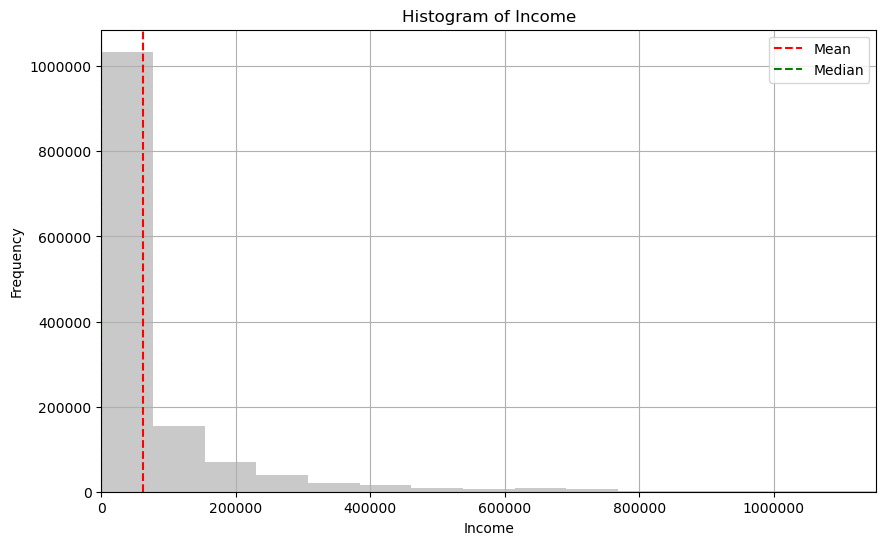

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(data['income2'], bins=15, color='#B8B8B8', edgecolor='none')

mean = data['income2'].mean()
median = data['income2'].median()

plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(median, color='green', linestyle='--', label='Median')

plt.xlim(data['income2'].min(), data['income2'].max())

plt.ticklabel_format(style='plain', useOffset=False)
plt.title('Histogram of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True)
plt.show()

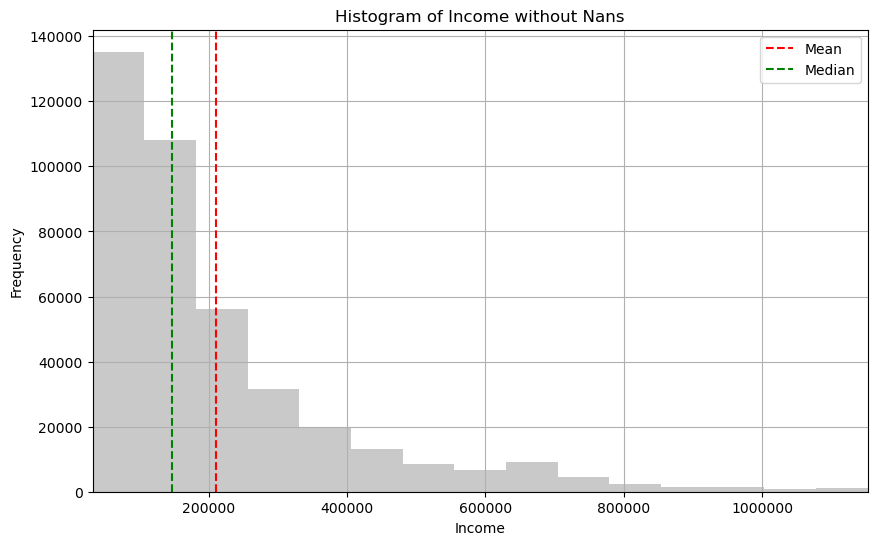

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(data['income'], bins=15, color='#B8B8B8', edgecolor='none')

mean = data['income'].mean()
median = data['income'].median()

plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(median, color='green', linestyle='--', label='Median')

plt.xlim(data['income'].min(), data['income'].max())

plt.ticklabel_format(style='plain', useOffset=False)
plt.title('Histogram of Income without Nans')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True)
plt.show()

#### Loans previously taken

In [63]:
data2 = copy.deepcopy(data)

data2.sort_values(by=['idperson', 'contract_date'], inplace=True)
data2['previous_loans_count'] = data2.groupby('idperson').cumcount()

In [64]:
data2['previous_loans_count'].describe()

count    1.374133e+06
mean     9.543783e+00
std      4.872487e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.370000e+03
Name: previous_loans_count, dtype: float64

In [65]:
data['previous_loans_count']=data2['previous_loans_count']

In [66]:
data['previous_loans_count'].value_counts()

0       601010
1       291328
2       150736
3        78248
4        41509
         ...  
1330         1
1340         1
1327         1
1349         1
1329         1
Name: previous_loans_count, Length: 1371, dtype: int64

In [108]:
data['previous_loans'] = data['previous_loans_count']
data['previous_loans'][data['previous_loans_count']==0] = 'No Loans'
data['previous_loans'][(data['previous_loans_count']>0) & (data['previous_loans_count']<=5)] = 'up to 5'
data['previous_loans'][data['previous_loans_count']>5] = 'more than 5'

In [109]:
data['previous_loans'].value_counts()

No Loans       601010
up to 5        585116
more than 5    188007
Name: previous_loans, dtype: int64

In [110]:
distribution = pd.crosstab(data['previous_loans'], data['classified'], normalize = 'index')
distribution

classified,0.0,1.0
previous_loans,,
No Loans,0.704210,0.295790
more than 5,0.963124,0.036876
up to 5,0.745126,0.254874


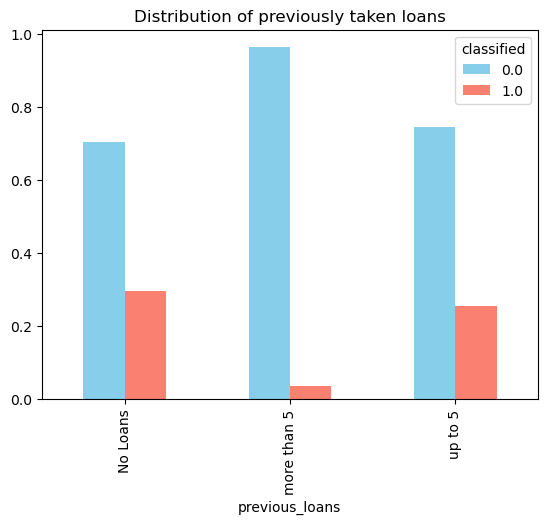

In [113]:
distribution.plot(kind = 'bar', color = ['skyblue', 'salmon'])
plt.title('Distribution of previously taken loans')
plt.show()

#### Bank Scores

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374133 entries, 0 to 1374132
Data columns (total 60 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   idperson                   1374133 non-null  float64       
 1   bankid                     1374133 non-null  int32         
 2   reg_code                   1374133 non-null  object        
 3   loan_type                  1374133 non-null  int8          
 4   currency                   1374133 non-null  object        
 5   price_nom                  1374133 non-null  float32       
 6   price_real                 1374133 non-null  float32       
 7   risk_class                 1374133 non-null  int8          
 8   last_reclass_date          1374133 non-null  object        
 9   overdue_date               1374133 non-null  object        
 10  collateral_id              1374133 non-null  int16         
 11  volume_contract            1374133 no

In [115]:
data['bankid'][data['bank_score2'].notnull()].unique()

array([24100, 22000, 15700])

In [116]:
data['bankid'][data['bank_score1'].notnull()].unique()

array([15700, 24100, 20500, 22000, 11800, 19300, 16300, 24700, 15100,
       16000])

In [117]:
data['bankid'].unique()

array([19300, 15700, 24100, 20500, 22000, 24700, 11800, 21700, 16600,
       16300, 15100, 11500, 25000, 21400, 16000, 20800])

In [118]:
data['score_exists'] = (~data['bank_score1'].isnull() | ~data['bank_score2'].isnull()).astype(int)

In [119]:
data['score_exists'].value_counts()

1    1044990
0     329143
Name: score_exists, dtype: int64

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374133 entries, 0 to 1374132
Data columns (total 60 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   idperson                   1374133 non-null  float64       
 1   bankid                     1374133 non-null  int32         
 2   reg_code                   1374133 non-null  object        
 3   loan_type                  1374133 non-null  int8          
 4   currency                   1374133 non-null  object        
 5   price_nom                  1374133 non-null  float32       
 6   price_real                 1374133 non-null  float32       
 7   risk_class                 1374133 non-null  int8          
 8   last_reclass_date          1374133 non-null  object        
 9   overdue_date               1374133 non-null  object        
 10  collateral_id              1374133 non-null  int16         
 11  volume_contract            1374133 no

In [121]:
data["bankid"].unique()

array([19300, 15700, 24100, 20500, 22000, 24700, 11800, 21700, 16600,
       16300, 15100, 11500, 25000, 21400, 16000, 20800])

#### Education

In [122]:
data.education.value_counts()

Միջնակարգ  հանրակրթական                    596930
Բարձրագույն մասնագիտական                   478768
Միջին մասնագիտական                         158759
Չունի տարրական                             123436
Տարրական հանրակրթական                       11295
Հիմնական հանրակրթական                        3897
Նախնական մասնագիտական (արհեստագործական)       823
Հետբուհական մասնագիտական                      225
Name: education, dtype: int64

In [123]:
data['education'] = data['education'].replace({'Հետբուհական մասնագիտական': 'Հետբուհական մասնագիտական', 'Հետբուհական մասնագիտական 8': 'Հետբուհական մասնագիտական'})

In [124]:
data['education'] = data['education'].replace('', data['education'].mode()[0])

In [125]:
data.education.value_counts()

Միջնակարգ  հանրակրթական                    596930
Բարձրագույն մասնագիտական                   478768
Միջին մասնագիտական                         158759
Չունի տարրական                             123436
Տարրական հանրակրթական                       11295
Հիմնական հանրակրթական                        3897
Նախնական մասնագիտական (արհեստագործական)       823
Հետբուհական մասնագիտական                      225
Name: education, dtype: int64

#### Employment

In [126]:
data.employment.value_counts()

              882332
Employed      469374
Unemployed     22427
Name: employment, dtype: int64

In [127]:
data['employment'][data['has_income']==1] = 'Employed'

In [128]:
data['employment'] = data['employment'].replace('Այլ', data['employment'].mode()[0])

In [129]:
data.employment.value_counts()

              882332
Employed      469374
Unemployed     22427
Name: employment, dtype: int64

In [130]:
data['employment'] = data['employment'].replace({'Աշխատում է որպես վարձու աշխատող ոչ պետական հատվածում': 'Employed',
                                                 'Աշխատում է որպես վարձու աշխատող պետական հատվածում': 'Employed', 
                                                 'Չի աշխատում՝ աշխատունակ  է':'Unemployed',
                                                'Չի աշխատում՝ անաշխատունակ է' : 'Unemployed',
                                                 'Ինքնազբաղված է` սեփական բիզնեսում կամ որպես ընտանիքի անդամ աշխատում է առանց վարձատրության': 'Employed', 
                                                 'Գործատու է ': 'Employed'})

In [131]:
data['employment'].value_counts()

              882332
Employed      469374
Unemployed     22427
Name: employment, dtype: int64

#### Gender

In [132]:
data.gender.value_counts()

F    687610
M    686523
Name: gender, dtype: int64

#### Marital Status

In [133]:
data.marital_status.value_counts()

Ամուսնացած (գրանցված և փաստացի)    980241
Երբևէ չամուսնացած                  393892
Name: marital_status, dtype: int64

Since most of the values are either Ամուսնացած (գրանցված և փաստացի) or Երբևէ չամուսնացած, we fill the others based on these two.

In [134]:
data['marital_status'] = data['marital_status'].replace('', data['marital_status'].mode()[0])
data['marital_status'] = data['marital_status'].replace({'Այրի/Կնակորույս': 'Երբևէ չամուսնացած', 'Այրի/Կնակորույս ': 'Երբևէ չամուսնացած', 'Ամուսնալուծված':'Երբևէ չամուսնացած' })

In [135]:
data.marital_status.value_counts()

Ամուսնացած (գրանցված և փաստացի)    980241
Երբևէ չամուսնացած                  393892
Name: marital_status, dtype: int64

#### Family Members

In [137]:
data['family_members'].fillna(data['family_members'].mean(), inplace=True)

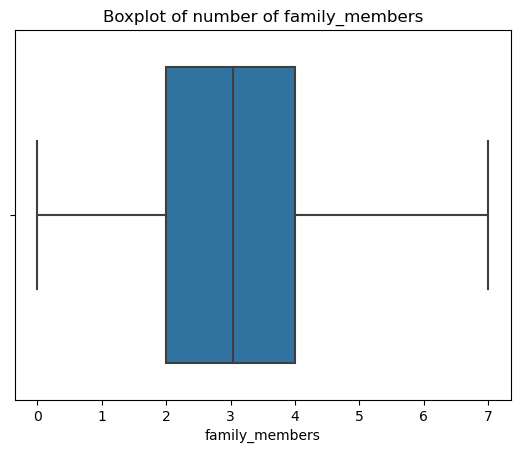

In [138]:
sns.boxplot(x=data['family_members'])
plt.title('Boxplot of number of family_members')
plt.show()

In [139]:
Q1 = data['family_members'].quantile(0.25) #quantile 1
Q3 = data['family_members'].quantile(0.75) #quantile 3

IQR = Q3 - Q1 

lower_bound = 0
upper_bound = Q3 + 1.5 * IQR

In [140]:
data['family_members'][data['family_members'] > upper_bound].count()

0

In [141]:
data.loc[data['family_members'] > upper_bound, 'family_members'] = data['family_members'].mean()

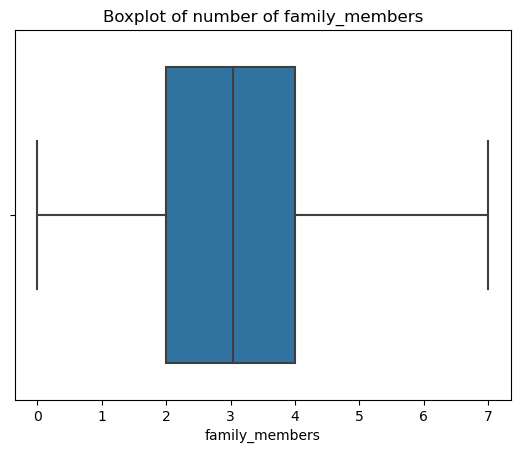

In [142]:
sns.boxplot(x=data['family_members'])
plt.title('Boxplot of number of family_members')
plt.show()

#### Baseline Model

In [143]:
data_base = data[[ 'idperson',
'bankid',
'loan_type',
'currency',
'price_nom',
'price_real',
'risk_class',
'year',
'month',
'quarter',
'maturity',
'education',
'family_members',
'gender',
'ispe',
'marital_status',
'last_reclass_date_bin',
'overdue_date_bin',
'amountAMD',
'Age',
'has_fico_score',
'income2',
'has_income',
'score_exists', 
'previous_loans',
'classified']]

In [144]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374133 entries, 0 to 1374132
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   idperson               1374133 non-null  float64
 1   bankid                 1374133 non-null  int32  
 2   loan_type              1374133 non-null  int8   
 3   currency               1374133 non-null  object 
 4   price_nom              1374133 non-null  float32
 5   price_real             1374133 non-null  float32
 6   risk_class             1374133 non-null  int8   
 7   year                   1374133 non-null  float32
 8   month                  1374133 non-null  float32
 9   quarter                1374133 non-null  float32
 10  maturity               1374133 non-null  float32
 11  education              1374133 non-null  object 
 12  family_members         1374133 non-null  float64
 13  gender                 1374133 non-null  object 
 14  ispe              

In [145]:
data_base['marital_status'][data_base['marital_status'] == "Ամուսնացած (գրանցված և փաստացի)"] = 'Married'
data_base['marital_status'][data_base['marital_status'] == "Երբևէ չամուսնացած"] = 'Single'

In [146]:
data_base['education'][data_base['education'] == "Բարձրագույն մասնագիտական"] = 'Master'
data_base['education'][data_base['education'] == "Միջին մասնագիտական"] = 'Bachelor'
data_base['education'][data_base['education'] == "Չունի տարրական"] = 'No Edu'
data_base['education'][data_base['education'] == "Տարրական հանրակրթական"] = 'Primary'
data_base['education'][data_base['education'] == "Միջնակարգ  հանրակրթական"] = 'Upper Secondary'
data_base['education'][data_base['education'] == "Հիմնական հանրակրթական"] = 'Lower Secondary'
data_base['education'][data_base['education'] == "Նախնական մասնագիտական (արհեստագործական)"] = 'Tertiary'
data_base['education'][data_base['education'] == "Հետբուհական մասնագիտական"] = 'Doctorate'

In [147]:
data_base.head(10)

,idperson,bankid,loan_type,currency,price_nom,price_real,risk_class,year,month,quarter,...,last_reclass_date_bin,overdue_date_bin,amountAMD,Age,has_fico_score,income2,has_income,score_exists,previous_loans,classified
0,1.107040e+12,19300,7,AMD,12.0,12.930000,0,2017.0,6.0,2.0,...,0,0,1.010936e+06,30,0,0.0,0,0,No Loans,0.0
1,1.107040e+12,19300,1,AMD,0.0,23.370001,0,2018.0,11.0,4.0,...,0,0,5.800000e+05,34,0,0.0,0,0,up to 5,0.0
2,1.107040e+12,19300,1,AMD,24.0,33.110001,0,2016.0,1.0,1.0,...,0,0,2.873000e+05,31,0,0.0,0,0,No Loans,0.0
3,1.107040e+12,15700,1,AMD,21.0,23.139999,0,2018.0,9.0,3.0,...,0,0,8.900000e+05,53,1,145030.0,1,1,No Loans,0.0
4,1.207040e+12,19300,1,AMD,18.0,19.559999,0,2021.0,3.0,1.0,...,0,0,3.000000e+05,42,0,0.0,0,0,No Loans,0.0
5,1.207040e+12,24100,1,AMD,0.0,0.000000,0,2018.0,11.0,4.0,...,0,0,8.790000e+04,32,0,0.0,0,1,No Loans,0.0
6,1.207040e+12,19300,1,AMD,12.0,12.680000,0,2016.0,3.0,1.0,...,0,0,4.889000e+05,34,0,0.0,0,0,No Loans,0.0
7,1.207040e+12,24100,1,AMD,0.0,0.000000,0,2019.0,12.0,4.0,...,0,0,4.628894e+05,25,0,0.0,0,1,No Loans,0.0
8,1.207040e+12,20500,1,AMD,19.5,23.660000,0,2021.0,1.0,1.0,...,0,0,3.560000e+05,26,0,0.0,0,1,up to 5,0.0
9,1.207040e+12,24100,1,AMD,0.0,0.000000,0,2021.0,4.0,2.0,...,0,0,7.720000e+04,55,0,0.0,0,1,No Loans,0.0


In [148]:
data_base['Default'] = 0
data_base['Default'][data_base['risk_class'] ==4] = 1

In [149]:
data_base.to_csv("data_baseline.csv")

### Exploratory Data Analyisis

In [151]:
data['Default'] = 0
data['Default'][data['risk_class'] ==4] = 1

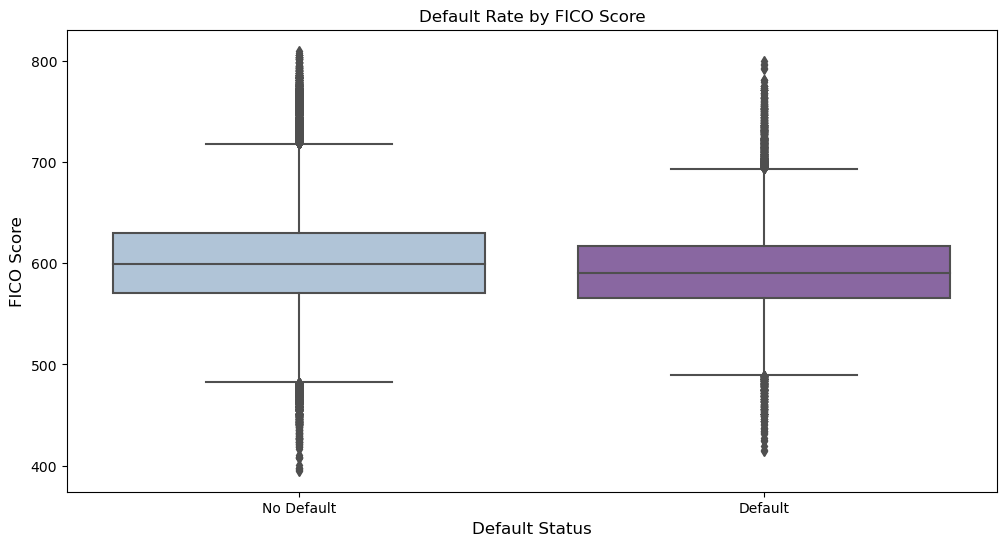

In [161]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='Default', y='fico_score', data=data, palette = 'BuPu')

# Adding titles and labels
plt.title('Default Rate by FICO Score')
plt.xlabel('Default Status', fontsize=12)
plt.ylabel('FICO Score', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Default', 'Default'])  # Set custom labels for the x-axis

# Show the plot
plt.show()

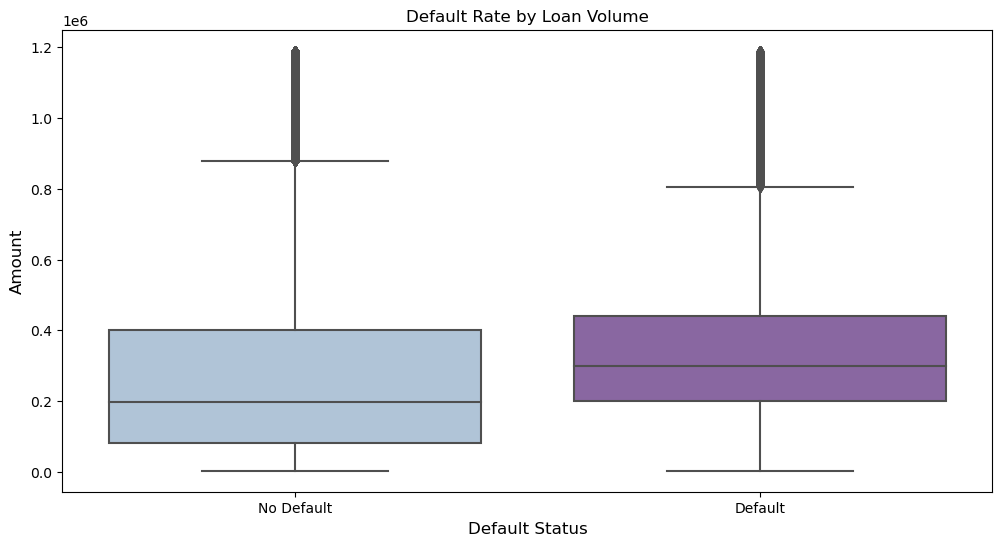

In [162]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='Default', y='amountAMD', data=data, palette = 'BuPu' )

plt.title('Default Rate by Loan Volume')
plt.xlabel('Default Status', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Default', 'Default']) 

plt.show()

#### The end